# Import Dependencies

In [4]:
import pandas as pd
import numpy as np

# Data Preperation

### Load Dataset

In [5]:
# Import dataset
dataset = pd.read_csv("./data/train.csv")

In [6]:
# divide preliminary dataset set into features and labels
X = dataset.drop(columns=["label"]) # features
y = dataset['label'] # labels

### Split the reduced-column dataset

In [7]:
from sklearn.model_selection import train_test_split
# split the dataset into Training and Test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, stratify=y) # 80 to 20% randomly

### Check Class distribution

{1: 4684, 7: 4401, 3: 4351, 9: 4188, 2: 4177, 6: 4137, 0: 4132, 4: 4072, 8: 4063, 5: 3795}


c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


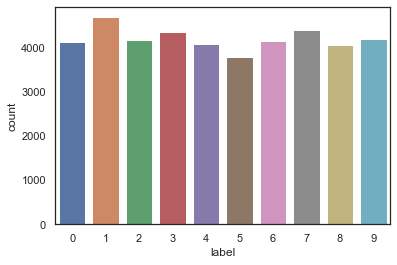

In [8]:
import seaborn as sns

sns.set(style='white', context='notebook', palette='deep')
# check whether class distribution is inbalanced in order to decide whether to use k-fold or stratified
print(dict(y.value_counts()))
g = sns.countplot(y)

# Modelling

### Function: save_model

In [9]:
from joblib import dump

def save_model(model,model_name):
    filename = str(model_name)+".pkl"
    dump(model,open("./models/"+filename,"wb"))

### Function load_model

In [10]:
from joblib import load

def load_model(model_name):
    filename = str(model_name)+".pkl"
    loaded_model = load(open(filename, 'rb'))
    return loaded_model

In [11]:
from pathlib import Path
from pickle import load
import os
def load_model(model_name):
    filename = str(model_name)+".pkl"
    current_directory = Path(__file__).parent #Get current directory
    file = open(os.path.join(current_directory, 'models', filename), 'rb') #rb = read bytes because we are reading the file
    return load(file) #We give it the file and it loads in everything from the file. That data is the loaded as the variable loadedData

### k-fold Cross Validation

In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# empty dictionary for saving k-fold cross validation score
kfold_scores = {'SVM':[],'DecTree':[],'RandomForest':[]}  

# evaluate a given model using cross-validation
def cross_val(model, X, y):
	# define the evaluation procedure
	cv = KFold(n_splits=5)
	
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

	print("%0.3f mean accuracy with a standard deviation of %0.4f" % (scores.mean(), scores.std()))
	return scores

### k-fold Cross Validation

In [13]:
from sklearn.model_selection import cross_validate

# empty dictionary for saving k-fold cross validation score
kfold_scores = {'SVM':[],'DecTree':[],'RandomForest':[]}  

# Overloading cross_val method if user wants to save the best scoring
def cross_val(model, X, y, name):
	# evaluate the model and collect the results, (cv=None uses 5-fold cross validation by default)
	scores = cross_validate(model, X, y, cv=None,
                            return_estimator=True,
                            scoring=('accuracy'))
	index = scores['test_score'].argmax()
	best_model = scores["estimator"][index]
	save_model(best_model,name)
	print("%0.3f mean accuracy with a standard deviation of %0.4f" % (scores["test_score"].mean(), scores["test_score"].std()))
	return best_model, scores["test_score"]

### Decision Tree (DT) Model

In [14]:
from sklearn.tree import DecisionTreeClassifier

clf_DT = DecisionTreeClassifier(max_depth=10) # creating DT classifier
model_DT, score = cross_val(clf_DT,X_train,y_train,"DecisionTree") # k-fold cross validation
kfold_scores['DecTree'] = score # note the accuracy score of DT model

0.840 mean accuracy with a standard deviation of 0.0063


### Random Forest (RF) Model

In [15]:
from sklearn.ensemble import RandomForestClassifier

clf_RF = RandomForestClassifier(random_state=None) # creating RF classifier
model_RF, score = cross_val(clf_RF,X_train,y_train,"RandomForest") # k-fold cross validation
kfold_scores['RandomForest'] = score # note the accuracy score of RF model

0.962 mean accuracy with a standard deviation of 0.0028


### Support Vector Machine (SVM) Model 

In [16]:
from sklearn import svm

clf_SVM = svm.SVC(decision_function_shape='ovo') # creating SVM classifier
model_SVM, score = cross_val(clf_SVM,X_train,y_train,"SVM") # k-fold cross validation
kfold_scores['SVM'] = score # note the accuracy score of SVM model

0.973 mean accuracy with a standard deviation of 0.0016


In [17]:
pd.DataFrame(kfold_scores)

,SVM,DecTree,RandomForest
0,0.971875,0.839732,0.962649
1,0.974851,0.842411,0.963690
2,0.975000,0.832887,0.966518
3,0.971280,0.850744,0.960268
4,0.972024,0.835119,0.958333


### Plot the k-fold cross validation results for all models

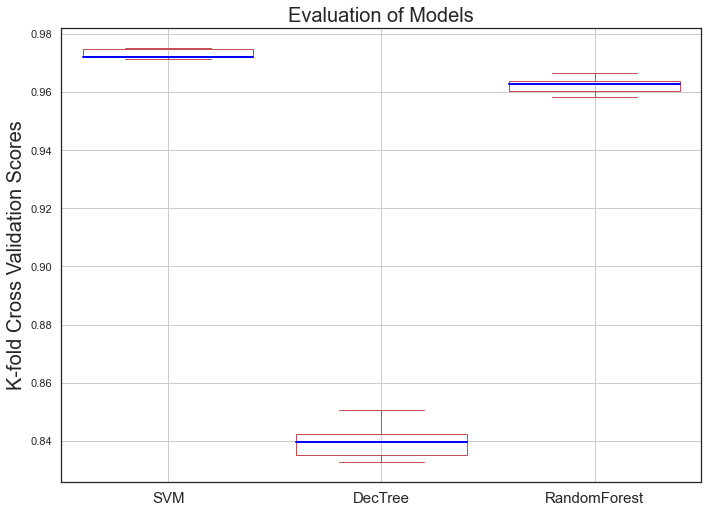

In [18]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(10,7))
data =[np.array(val) for  val in kfold_scores.values()]
bp = ax.boxplot(data,widths=[0.8,0.8,0.8])
# change the color of the meanline

for _, line_list in bp.items():
    for line in line_list:
        line.set_color('r')
for meanline in bp['medians']:
    meanline.set_color('blue')
    meanline.set(linewidth=2)
plt.xticks([1, 2, 3], [key for key in kfold_scores.keys()],fontsize=15)
plt.ylabel("K-fold Cross Validation Scores", fontsize=20)
plt.tight_layout()
plt.title("Evaluation of Models",fontsize=20)
plt.grid()
plt.show()

# Prediction

In [19]:
from sklearn.metrics import accuracy_score

test_accuracy={'SVM':[],'DecTree':[],'RandomForest':[]}

### Predict by Decision Tree Model

In [20]:
# make predictions for DT model using test set and note its accuracy
prediction = model_DT.predict(X_test) # making predictions for DT model
test_accuracy['DecTree'] = accuracy_score(y_test,prediction) # note the accuracy of DT model

### Predict by Random Forest Model

In [21]:
# make predictions for RF model using test set and note its accuracy
prediction = model_RF.predict(X_test) # making predictions for RF model
test_accuracy['RandomForest'] = accuracy_score(y_test,prediction) # note the accuracy of RF model

### Predict by SVM Model

In [22]:
# make predictions for SVM model using test set and note its accuracy
prediction = model_SVM.predict(X_test) # making predictions for SVM model
test_accuracy['SVM'] = accuracy_score(y_test,prediction) # note the accuracy of SVM model

In [23]:
test_accuracy

{'SVM': 0.9745238095238096,
 'DecTree': 0.8430952380952381,
 'RandomForest': 0.9597619047619048}

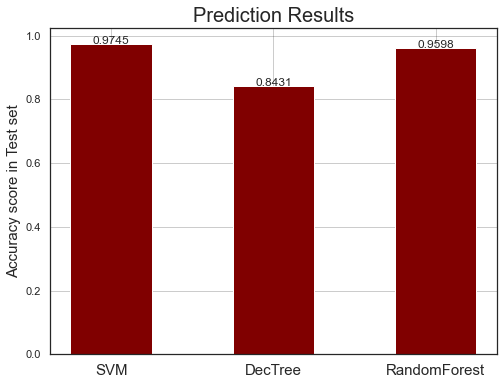

In [24]:
import matplotlib.pyplot as plt

data = [val for val in test_accuracy.values()]
methods = [key for key in test_accuracy.keys()]

def add_text(Xtick):
    for x in Xtick:
        plt.text(x,test_accuracy[x],"%.4f" % test_accuracy[x],fontsize=12,ha="center")
fig = plt.figure(figsize = (8, 6))
plt.bar(methods, data, width=0.5, color="maroon")
add_text(methods)
plt.ylabel("Accuracy score in Test set",fontsize=15)
plt.xticks(fontsize=15)
plt.title("Prediction Results",fontsize=20)
plt.grid(color="black", alpha=0.2)
plt.show()

### Predict Test Data

In [43]:
test_Data = pd.read_csv("./data/test.csv")

In [41]:
# Export Decision Tree Model Predictions
pred_DT = model_DT.predict(test_Data)
pd.read_csv("./data/sample_submission.csv")
df = pd.DataFrame({'ImageId':range(1,len(pred_DT)+1),'Label':pred_DT})
df.to_csv("submission1.csv",index=False)

In [46]:
# Export Random Forest Model Predictions
pred_RF = model_RF.predict(test_Data)
pd.read_csv("./data/sample_submission.csv")
df = pd.DataFrame({'ImageId':range(1,len(pred_RF)+1),'Label':pred_RF})
df.to_csv("submission2.csv",index=False)

In [47]:
# Export SVM Model Predictions
pred_SVM = model_SVM.predict(test_Data)
pd.read_csv("./data/sample_submission.csv")
df = pd.DataFrame({'ImageId':range(1,len(pred_SVM)+1),'Label':pred_SVM})
df.to_csv("submission3.csv",index=False)